<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/explicabilidad_de_modelos/mapa_de_activaci%C3%B3n_de_clases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM visualización de activación de clase

**Objetivo:** Obtener un mapa de calor de activación de clases para un modelo de clasificación de imágenes.

## Introducción

En este *notebook* se implementa la técnica "Gradient-weighted Class Activation Mapping" mejor conocido como Grad-CAM.

In [ ]:
!nvidia-smi

Wed Jan 25 03:11:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Librerías

In [ ]:
import numpy as np
import tensorflow as tf

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display

## Parámetros configurables

Se precarga el modelo Xception. Para obtener los valores de `last_conv_layer_name` se recomienda utilizar el método `model.summary()`
para inspeccionar los nombres de todas las capas del modelo.

In [ ]:
model = tf.keras.applications.Xception(include_top=True, weights="imagenet", classes=1000, classifier_activation="softmax")
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions

In [ ]:
img_size = (299, 299)
last_conv_layer_name = "block14_sepconv2_act"

296416/296416 [==============================] - 0s 0us/step


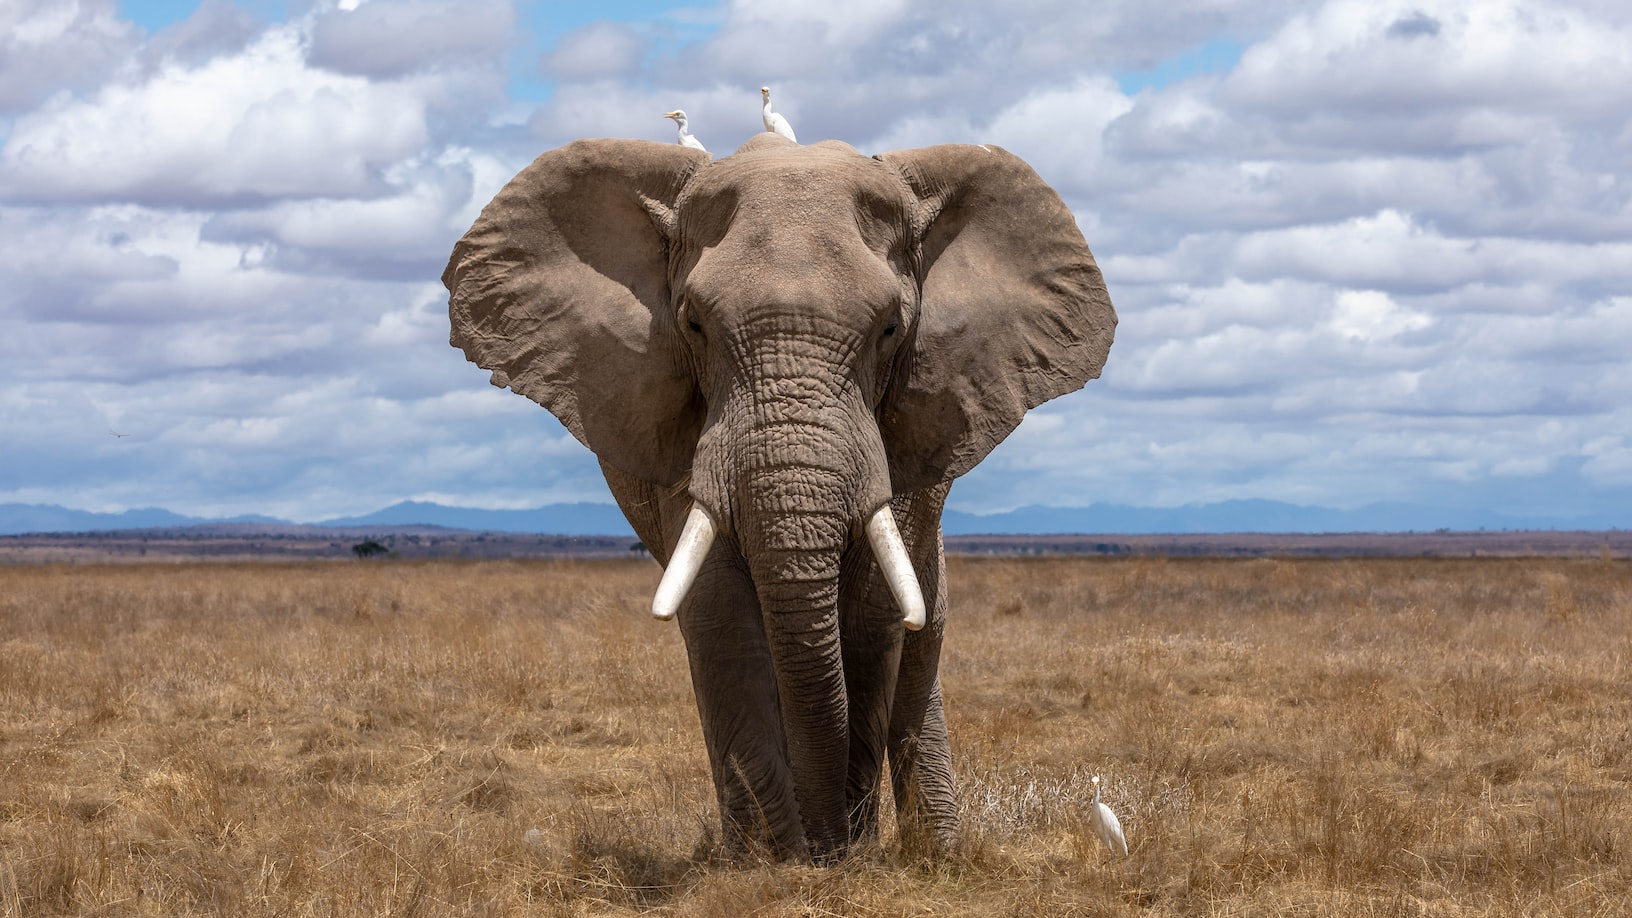

In [ ]:
img_path = tf.keras.utils.get_file("african_elephant.jpg", "https://images.unsplash.com/photo-1557050543-4d5f4e07ef46?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1632&q=80")
display(Image(img_path))

## El algoritmo Grad-CAM

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## Prueba del modelo

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n01871265', 'tusker', 8.769467)]


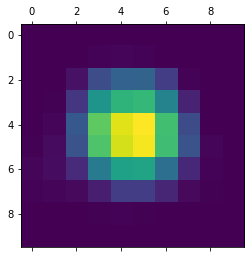

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Crear una visualización superpuesta

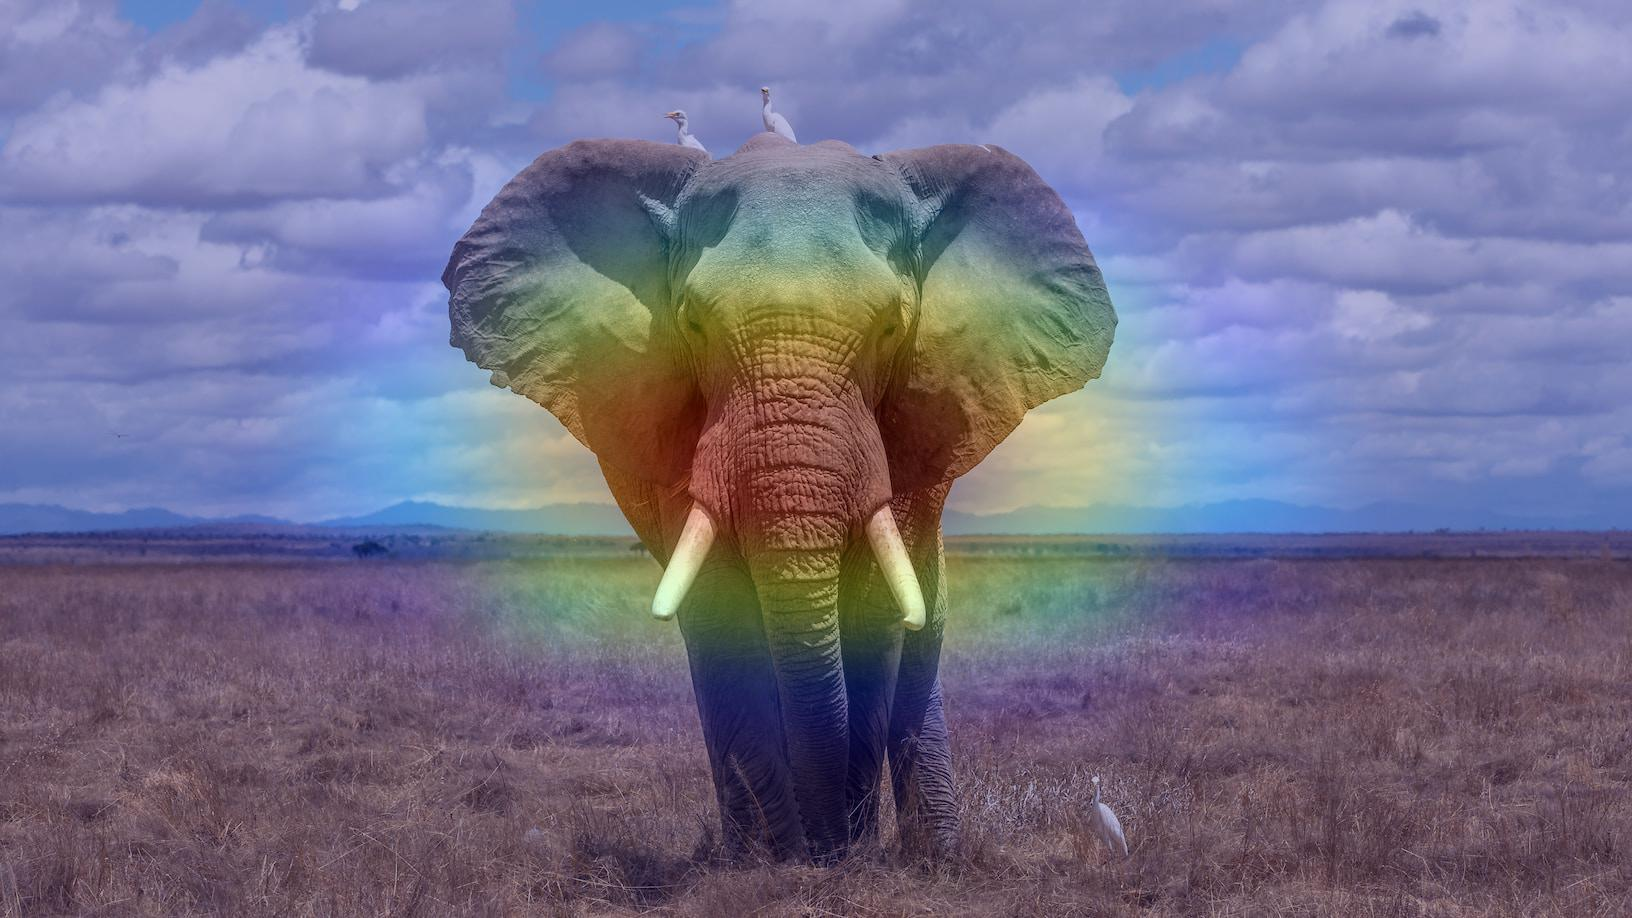

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

## Pruebas en otras imágenes

Veremos cómo el algorimo de Grad-CAM explica los resultados del modelo para una imagen de etiquetas múltiples. Se prueba una imagen con un gato y un perro juntos para visualizar cómo se comporta la salida.

72452/72452 [==============================] - 0s 4us/step


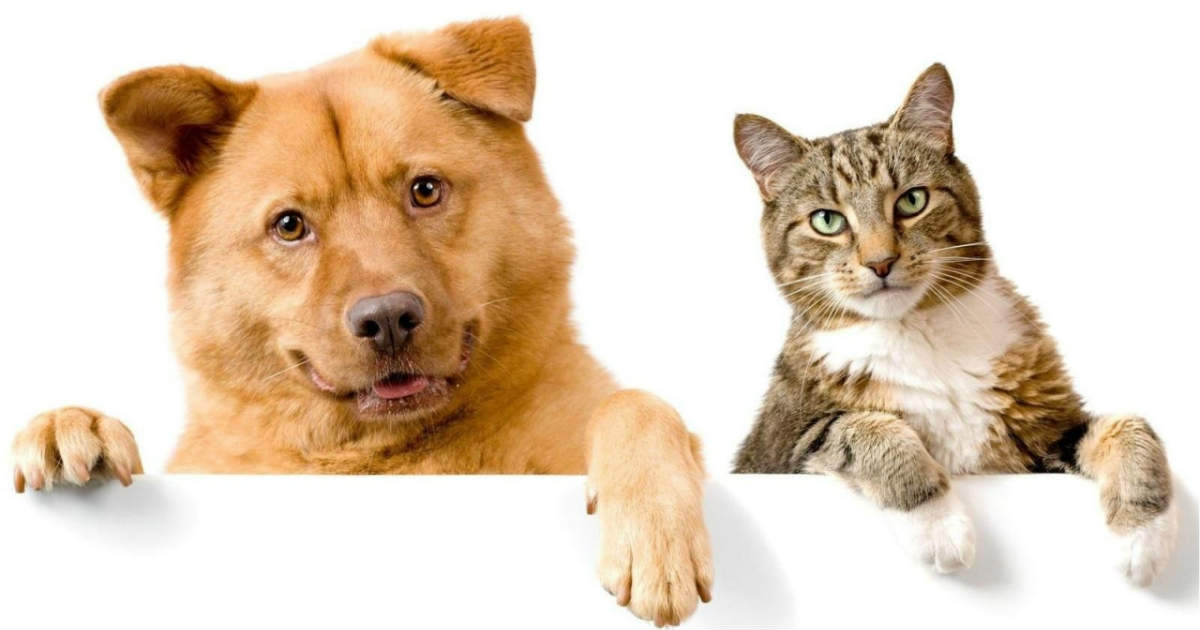

1/1 [==============================] - 0s 21ms/step
Predicted: [('n02112137', 'chow', 4.6112413), ('n02124075', 'Egyptian_cat', 4.3817387)]


In [ ]:
img_path = tf.keras.utils.get_file("cat_and_dog.jpg", "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

Se genera un mapa de calor de activación de clase para un perro de raza "chow", donde su índice de clase es 260.

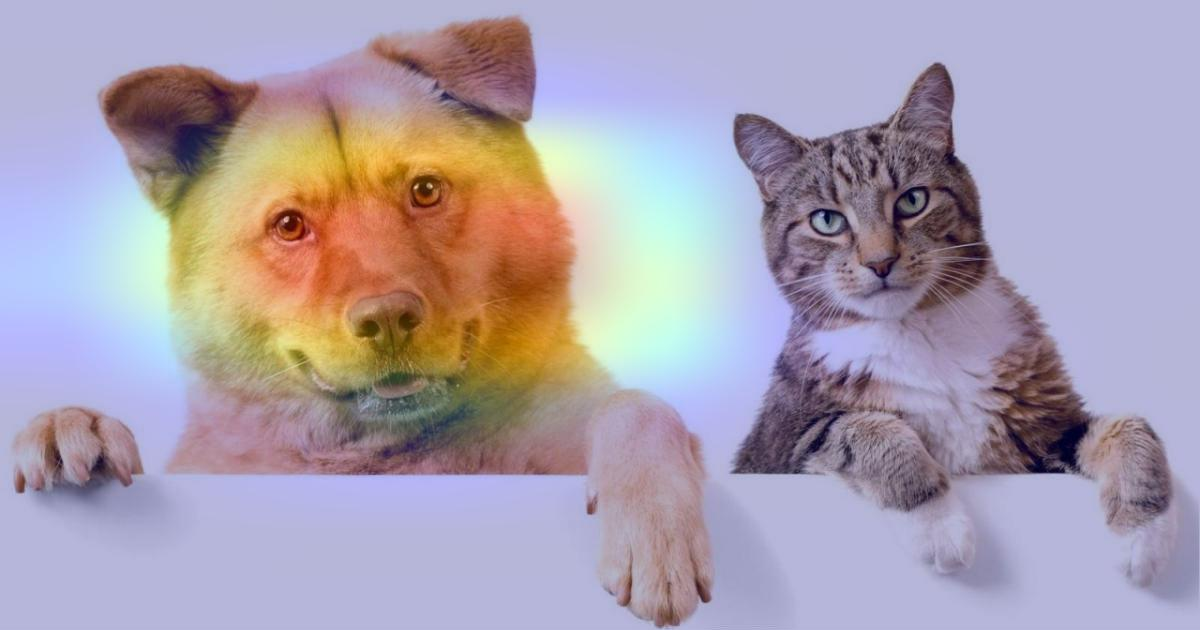

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)
save_and_display_gradcam(img_path, heatmap)

Ahora se genera otro mapa de calor de activación de clase para "gato egipcio", coyu índice de clase es 285.

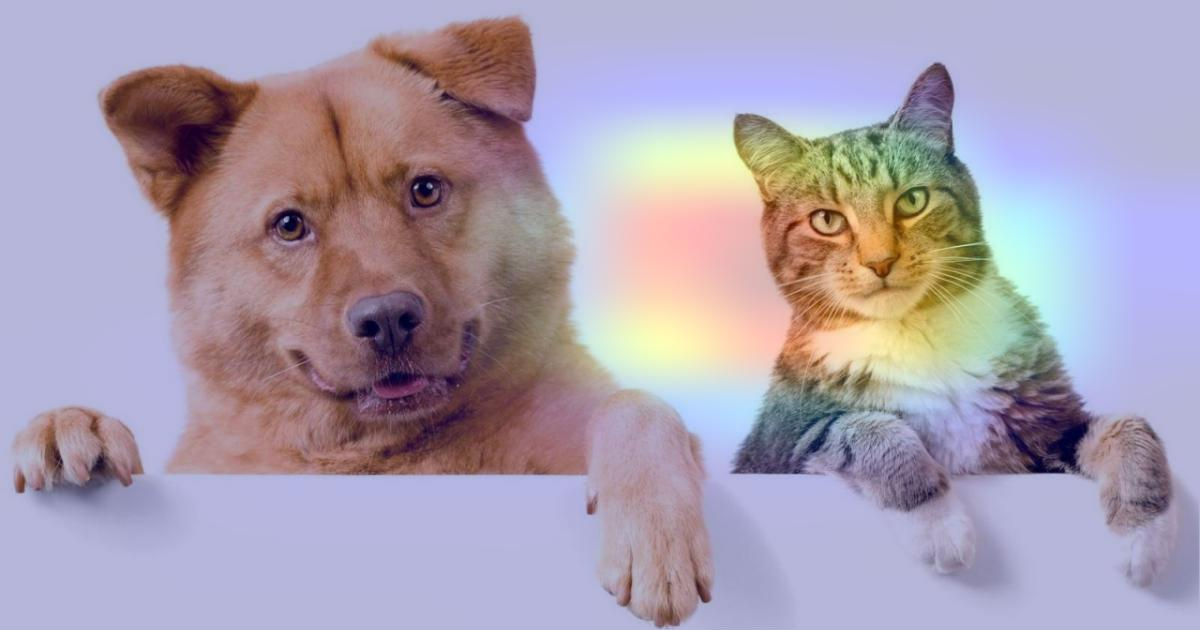

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)
save_and_display_gradcam(img_path, heatmap)